In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imdb-dataset-of-50k-movie-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F134715%2F320111%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240815%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240815T104713Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8399cc65b9da5df278cee6ffcde863bbc2abdd563d55f0c017ac331cb1fcece13d92ae7385f8a460a70f9e7b349f8fc0c5fb23bfd1a05c42ac4d1697a9ef7a494caf40abe99a3a6e4faa42da69972bbbb5ec9829be7111ccadbb9f9a2f1dd7c8fb57544314d2a742bfb4277c52bf5f005a3df67d2a3af1c56ca1e8624c5719900b55bc12becf67eca67caee16b1d9e2826312e3e085d7e1016bde75e61534305ffc8c43e4f078574964f06c638c523de703c1c04a12fc39f817c9c95b529b5a5fa62534b2372c534efe923cdb2a8a48b5574330b5227d8ee58e01d00e42d2f076b341c31d9e475eaba1f9aec001708d3a736fe63fdb12db8b3b4f5482068a59c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26962657 bytes downloaded
Downloaded and uncompressed: imdb-dataset-of-50k-movie-reviews
Data source import complete.



# 1. Importing necessary libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv



# 2. Preparing the data

In [ ]:
df_review = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df_review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


This dataset contains 50000 rows; however, to train our model faster in the following steps, we’re going to take a smaller sample of 10000 rows. This small sample will contain 9000 positive and 1000 negative reviews to make the data imbalanced (so I can teach you undersampling and oversampling techniques in the next step)

In [ ]:
df_positive = df_review[df_review['sentiment']=='positive'][:9000]
df_negative = df_review[df_review['sentiment']=='negative'][:1000]

df_review_imb = pd.concat([df_positive,df_negative ])

## Dealing with Imbalanced Classes

In most cases, you’ll have a large amount of data for one class, and much fewer observations for other classes. This is known as imbalanced data because the number of observations per class is not equally distributed.

Let’s take a look at how our df_review_imb dataset is distributed.

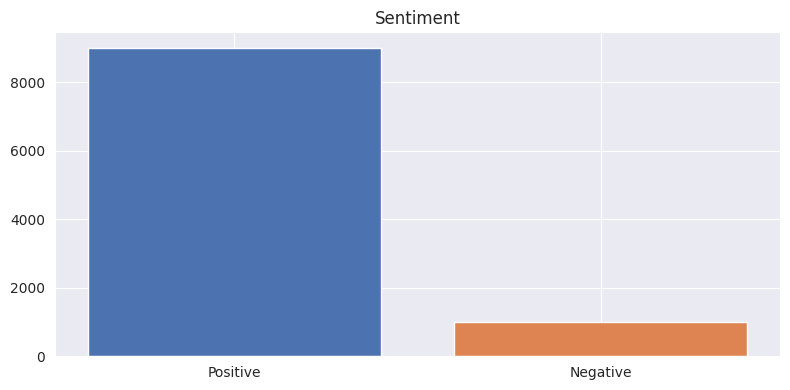

In [ ]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=df_review_imb.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

To resample our data we use the imblearn library. You can either undersample positive reviews or oversample negative reviews (you need to choose based on the data you’re working with). In this case, we’ll use the RandomUnderSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state= 0)
df_review_bal,df_review_bal['sentiment']=rus.fit_resample(df_review_imb[['review']],df_review_imb['sentiment'])


df_review_bal

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
10,Phil the Alien is one of those quirky films wh...,negative
11,I saw this movie when I was about 12 when it c...,negative
...,...,...
10833,Knute Rockne led an extraordinary life and his...,positive
1039,At the height of the 'Celebrity Big Brother' r...,positive
5255,This is another of Robert Altman's underrated ...,positive
12237,This movie won a special award at Cannes for i...,positive


We can compare the imbalanced and balanced dataset with the following code.

In [ ]:
print(df_review_imb.value_counts('sentiment'))
print(df_review_bal.value_counts('sentiment'))

sentiment
positive    9000
negative    1000
Name: count, dtype: int64
sentiment
negative    1000
positive    1000
Name: count, dtype: int64



## Splitting data into train and test set


In [ ]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df_review_bal,test_size =0.33,random_state=42)

In [ ]:
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

In [ ]:
train_y.value_counts()

,count
sentiment,
negative,675
positive,665



# 3.Text Representation (Bag of words)


Classifiers and learning algorithms expect numerical feature vectors rather than raw text documents. This is why we need to turn our movie review text into numerical vectors.

we’ll use bag of words (BOW) since we care about the frequency of the words in text reviews; however, the order of words is irrelevant. Two common ways to represent bag of words are CountVectorizer and Term Frequency, Inverse Document Frequency (TF-IDF)

we want to identify unique/representative words for positive reviews and negative reviews, so we’ll choose the TF-IDF. To turn text data into numerical vectors with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)
# also fit the test_x_vector
test_x_vector = tfidf.transform(test_x)


Finally, let's also transform the test_x_vector, so we can test the accuracy of the model later

In [ ]:
pd.DataFrame.sparse.from_spmatrix(train_x_vector,
                                  index=train_x.index,
                                  columns=tfidf.get_feature_names_out())

,00,000,007,01pm,02,04,08,10,100,1000,...,zooming,zooms,zues,zzzzzzzzzzzzzzzzzz,æon,élan,émigré,ísnt,ïn,ünfaithful
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042791,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4.Model Selection

In our example, our input (review) and output (sentiment) are clearly identified, so we can say we have labeled input and output data; therefore, we’re dealing with supervised learning.

We will benchmark the four classification models.



##  Support Vector Machine(SVM)


In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', probability=True)
svc.fit(train_x_vector, train_y)

SVC(kernel='linear', probability=True)

In [ ]:
print(svc.predict(tfidf.transform(['A good movie'])))
print(svc.predict(tfidf.transform(['An excellent movie'])))
print(svc.predict(tfidf.transform(['I did not like this movie at all I gave this movie away'])))

['positive']
['positive']
['negative']



## Compliment naive bayes


In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
cnb = ComplementNB()
cnb.fit(train_x_vector, train_y)

ComplementNB()


## MLP Classifier


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42, max_iter=300)
mlp.fit(train_x_vector, train_y)

MLPClassifier(max_iter=300, random_state=42)


## Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(train_x_vector,train_y)

LogisticRegression()

>Note: Here notice that we are using review dataframe in vectorized form and sentiment dataframe in normal form it is so that model evaluates the vectorized values of review dataframe and gives out output in normal english not in a vectorized form so that it can be readable to us

#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(train_x_vector, train_y)


RandomForestClassifier(random_state=42)


# 5. Model Evaluation


## Mean Accuracy

In [ ]:
print(svc.score(test_x_vector, test_y))
print(cnb.score(test_x_vector, test_y))
print(mlp.score(test_x_vector, test_y))
print(log_reg.score(test_x_vector, test_y))
print(rf.score(test_x_vector, test_y))

0.8409090909090909
0.8272727272727273
0.8242424242424242
0.8303030303030303
0.8015151515151515


SVM and Logistic Regression perform better than the other two classifiers, with SVM having a slight advantage (84% of accuracy).Thus,we’ll focus only on SVM.

## F1 Score

F1 Score is the weighted average of Precision and Recall. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. Also, F1 takes into account how the data is distributed, so it’s useful when you have data with imbalance classes.

In [ ]:
from sklearn.metrics import f1_score
svc_pred = svc.predict(test_x_vector)
cnb_pred = cnb.predict(test_x_vector)
mlp_pred = mlp.predict(test_x_vector.toarray())
log_reg_pred = log_reg.predict(test_x_vector)
rf_pred = rf.predict(test_x_vector)

# F1 Scores
svc_f1 = f1_score(test_y, svc_pred, labels=['positive', 'negative'], average=None)
cnb_f1_score = f1_score(test_y, cnb_pred, labels=['positive', 'negative'], average=None)
mlp_f1_score = f1_score(test_y, mlp_pred, labels=['positive', 'negative'], average=None)
log_reg_f1 = f1_score(test_y, log_reg_pred, labels=['positive', 'negative'], average=None)
rf_f1 = f1_score(test_y, rf_pred, labels=['positive', 'negative'], average=None)

In [ ]:
print("\nSVM F1 Score:", svc_f1)
print("CNB F1 Score:", cnb_f1_score)
print("MLP F1 Score:", mlp_f1_score)
print("Logistic Regression F1 Score:", log_reg_f1)
print("Random Forest F1 Score:", rf_f1)


SVM F1 Score: [0.84671533 0.83464567]
CNB F1 Score: [0.82018927 0.83381924]
MLP F1 Score: [0.82686567 0.82153846]
Logistic Regression F1 Score: [0.83815029 0.82165605]
Random Forest F1 Score: [0.80121396 0.80181543]


## Classification report

In [ ]:
# Classification Reports
svc_report = classification_report(test_y, svc_pred, labels=['positive', 'negative'])
cnb_report = classification_report(test_y, cnb_pred, labels=['positive', 'negative'])
mlp_report = classification_report(test_y, mlp_pred, labels=['positive', 'negative'])
log_reg_report = classification_report(test_y, log_reg_pred, labels=['positive', 'negative'])
rf_report = classification_report(test_y, rf_pred, labels=['positive', 'negative'])

In [ ]:
print("\nSVM Classification Report:\n", svc_report)
print("CNB Classification Report:\n", cnb_report)
print("MLP Classification Report:\n", mlp_report)
print("Logistic Regression Classification Report:\n", log_reg_report)
print("Random Forest Classification Report:\n", rf_report)


SVM Classification Report:
               precision    recall  f1-score   support

    positive       0.83      0.87      0.85       335
    negative       0.85      0.82      0.83       325

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660

CNB Classification Report:
               precision    recall  f1-score   support

    positive       0.87      0.78      0.82       335
    negative       0.79      0.88      0.83       325

    accuracy                           0.83       660
   macro avg       0.83      0.83      0.83       660
weighted avg       0.83      0.83      0.83       660

MLP Classification Report:
               precision    recall  f1-score   support

    positive       0.83      0.83      0.83       335
    negative       0.82      0.82      0.82       325

    accuracy                           0.82       660
   macro avg       0.82      0.82      0.82

## Confusion Matrix

A confusion matrix is a table that allows visualization of the performance of an algorithm. This table typically has two rows and two columns that report the number of false positives, false negatives, true positives, and true negatives

In [ ]:
# Confusion Matrices
svc_conf_mat = confusion_matrix(test_y, svc_pred, labels=['positive', 'negative'])
cnb_conf_mat = confusion_matrix(test_y, cnb_pred, labels=['positive', 'negative'])
mlp_conf_mat = confusion_matrix(test_y, mlp_pred, labels=['positive', 'negative'])
log_reg_conf_mat = confusion_matrix(test_y, log_reg_pred, labels=['positive', 'negative'])
rf_conf_mat = confusion_matrix(test_y, rf_pred, labels=['positive', 'negative'])

In [ ]:
print("\nSVM Confusion Matrix:\n", svc_conf_mat)
print("Decision Tree Confusion Matrix:\n", cnb_conf_mat)
print("GaussianNB Confusion Matrix:\n", mlp_conf_mat)
print("Logistic Regression Confusion Matrix:\n", log_reg_conf_mat)
print("Random Forest Confusion Matrix:\n", rf_conf_mat)


SVM Confusion Matrix:
 [[290  45]
 [ 60 265]]
Decision Tree Confusion Matrix:
 [[260  75]
 [ 39 286]]
GaussianNB Confusion Matrix:
 [[277  58]
 [ 58 267]]
Logistic Regression Confusion Matrix:
 [[290  45]
 [ 67 258]]
Random Forest Confusion Matrix:
 [[264  71]
 [ 60 265]]


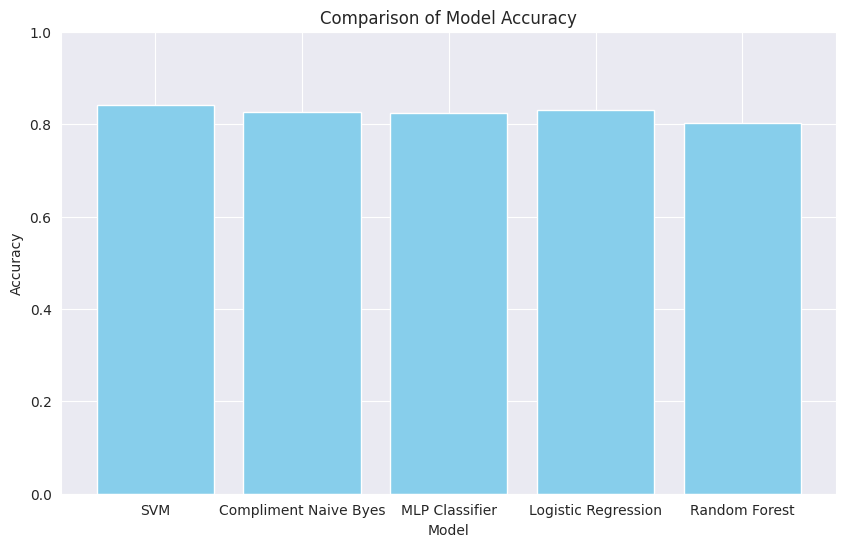

In [ ]:
import matplotlib.pyplot as plt

# Dictionary to store the accuracy scores of each model
accuracy_scores = {
    'SVM': svc.score(test_x_vector, test_y),
    'Compliment Naive Byes': cnb.score(test_x_vector, test_y),
    'MLP Classifier': mlp.score(test_x_vector, test_y),
    'Logistic Regression': log_reg.score(test_x_vector, test_y),
    'Random Forest': rf.score(test_x_vector, test_y)
}

# Plotting the accuracy scores
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.ylim(0, 1)
plt.savefig('model_comparison_accuracy.png')
plt.show()


SVM Accuracy: 0.8409090909090909


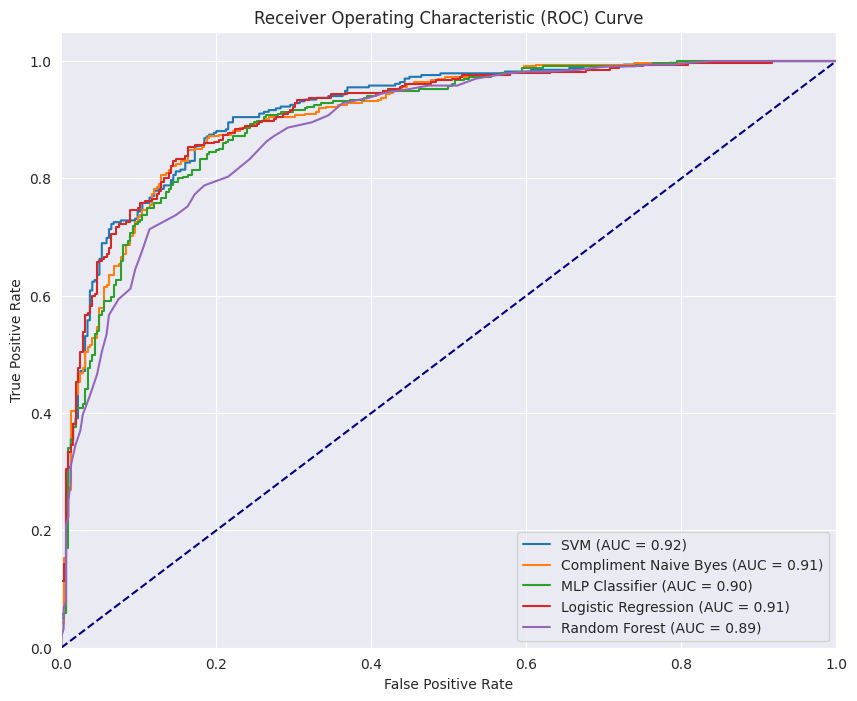

In [ ]:
from sklearn.svm import SVC

# Reinitialize the SVC model with probability=True
svc = SVC(kernel='linear', probability=True)
svc.fit(train_x_vector, train_y)

# Evaluate the SVM model again
svc_score = svc.score(test_x_vector, test_y)
print(f'SVM Accuracy: {svc_score}')

# Now, proceed with the ROC curve and model comparison plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

models = {
    'SVM': svc,
    'Compliment Naive Byes': cnb,
    'MLP Classifier': mlp,
    'Logistic Regression': log_reg,
    'Random Forest': rf
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    if name == 'Gaussian Naive Bayes':
        probas = model.predict_proba(test_x_vector.toarray())
    else:
        probas = model.predict_proba(test_x_vector)

    fpr, tpr, _ = roc_curve(test_y, probas[:, 1], pos_label='positive')
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('model_comparison_roc.png')
plt.show()
